In [1]:
# Required Libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost shap pyswarms joblib
!pip install lightgbm --install-option=--gpu
!pip install torch torchvision torchaudio skorch


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --install-option


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_score, recall_score, confusion_matrix,
    precision_recall_curve, roc_curve
)
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import shap
from pyswarms.single.global_best import GlobalBestPSO
import joblib
import warnings
import time

warnings.filterwarnings("ignore")

In [3]:
# --- Directories ---
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [4]:
# --- Load Dataset ---
file_path = "Data.xlsx"
try:
    df = pd.read_excel(file_path)
    df = df.drop(columns=[df.columns[0]])  # Drop N.N (assuming it's an unnecessary ID column)
    print("Dataset loaded successfully.")
    print(f"Initial data shape: {df.shape}")

    # Features & Target
    y = df['Lslide_Sta']
    X = df.drop(columns=['Lslide_Sta'])
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
    exit() # Exit if data file is not found
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit() # Exit on other loading errors

Dataset loaded successfully.
Initial data shape: (500000, 71)
Features (X) shape: (500000, 70)
Target (y) shape: (500000,)


In [ ]:
df.head()

In [5]:
# --- SHAP-RFE Selection ---
def shap_rfe_selection_adaptive(X, y, estimator=None, min_features=15, shap_thresh=0.05, tol=0.001):
    """
    Performs SHAP-RFE feature selection with an adaptive stopping criterion.

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
        estimator: The model to use for feature importance (default: XGBClassifier).
        min_features (int): The minimum number of features to retain.
        shap_thresh (float): SHAP value threshold below which features are dropped.
        tol (float): Tolerance for performance improvement to continue selection.

    Returns:
        list: Names of the selected features.
    """
    if estimator is None:
        estimator = XGBClassifier(
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

    features = list(X.columns)
    X_curr = X.copy()
    best_score = -np.inf # Initialize with a very low score
    best_features = features.copy()

    print(f"Starting SHAP-RFE with {len(features)} initial features. Minimum features: {min_features}")
    while len(features) > min_features:
        model = clone(estimator)
        model.fit(X_curr, y)
        score = model.score(X_curr, y) # Using training score for internal RFE logic

        if score > best_score + tol:
            best_score = score
            best_features = features.copy()
            # print(f"  Current score: {score:.4f}, Best score updated. Features: {len(best_features)}")
        # else:
            # print(f"  Current score: {score:.4f}, no significant improvement detected.")

        # Sample for SHAP to speed up computation
        sample_size = min(500, len(X_curr))
        X_sample = X_curr.sample(sample_size, random_state=42)

        explainer = shap.TreeExplainer(model, approximate=True)
        shap_values = explainer.shap_values(X_sample)
        shap_values = shap_values[1] if isinstance(shap_values, list) else shap_values # For binary classification
        mean_shap = np.abs(shap_values).mean(axis=0)

        # Create a list of (feature, mean_shap_value) tuples and sort them by SHAP value
        feature_shap_pairs = sorted(zip(features, mean_shap), key=lambda x: x[1])
        
        # Identify features below threshold
        below_thresh_candidates = [f for f, val in feature_shap_pairs if val < shap_thresh]
        
        if not below_thresh_candidates: # No features below threshold, remove the single least important
            if len(features) > min_features:
                feature_to_remove = feature_shap_pairs[0][0]
                features.remove(feature_to_remove)
                X_curr = X_curr.drop(columns=[feature_to_remove])
                # print(f"  Removing least important feature: '{feature_to_remove}'. Features remaining: {len(features)}")
            else:
                break # Cannot remove more features if at or below min_features
        else:
            # Determine which features to actually remove to respect min_features
            features_to_remove = []
            for f_cand in below_thresh_candidates:
                if len(features) - len(features_to_remove) - 1 >= min_features:
                    features_to_remove.append(f_cand)
                else:
                    break # Stop if removing next would go below min_features
            
            if not features_to_remove and len(features) > min_features: # If no candidates to remove that maintain min_features, remove the single least important
                feature_to_remove = feature_shap_pairs[0][0]
                if len(features) - 1 >= min_features:
                    features_to_remove.append(feature_to_remove)


            if features_to_remove:
                features = [f for f in features if f not in features_to_remove]
                X_curr = X_curr[features]
                # print(f"  Removed {len(features_to_remove)} features. Features remaining: {len(features)}")
            else:
                break # No features could be removed while maintaining constraints

    print(f"SHAP-RFE completed. Selected {len(best_features)} features.")
    return best_features


# --- Deep Swarm Selection ---
def deep_swarm_selection_adaptive(X, y, num_particles=5, n_iterations=5, min_features=15, feature_penalty=1.0):
    """
    Performs feature selection using Deep Swarm Optimization (PSO).

    Args:
        X (pd.DataFrame): The feature DataFrame.
        y (pd.Series): The target Series.
        num_particles (int): Number of particles in PSO.
        n_iterations (int): Number of iterations for PSO.
        min_features (int): Minimum number of features to select.
        feature_penalty (float): Penalty coefficient for more features.

    Returns:
        list: Names of the selected features.
    """
    # Sample data for faster PSO iterations
    X_sample = X.sample(n=min(500, len(X)), random_state=42)
    y_sample = y.loc[X_sample.index]
    n_features = X_sample.shape[1]

    # Initialize with all features selected as the best mask as a fallback
    best_mask = np.ones(n_features, dtype=bool)
    # Calculate initial best_score based on all features to provide a starting point for comparison
    clf_initial = MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, random_state=42, activation='relu', solver='adam') 
    try:
        clf_initial.fit(X_sample, y_sample)
        initial_score = clf_initial.score(X_sample, y_sample)
        best_score = initial_score - feature_penalty * (n_features / n_features) # Penalize full set too
    except Exception as e:
        print(f"Warning: Initial MLP training failed: {e}. Setting best_score to -inf.")
        best_score = -np.inf

    print(f"Starting Deep Swarm Selection with {n_features} initial features. Min features: {min_features}")

    def objective_function(particles):
        nonlocal best_score, best_mask
        scores = []
        for particle in particles:
            mask = particle > 0.5  # Convert particle position to a binary mask
            n_selected = mask.sum()
            
            if n_selected < min_features:
                scores.append(1e6)  # A very high cost to strongly discourage insufficient features
                continue
            elif n_selected == 0:
                scores.append(1e6)
                continue

            clf = MLPClassifier(hidden_layer_sizes=(64,), max_iter=200, random_state=42, activation='relu', solver='adam')
            try:
                clf.fit(X_sample.loc[:, mask], y_sample)
                score = clf.score(X_sample.loc[:, mask], y_sample)
                penalized_score = score - feature_penalty * (n_selected / n_features)
            except ValueError as e:
                # print(f"Warning during MLP training for particle: {e}. Assigning high penalty.")
                penalized_score = -1e6 # High penalty for invalid feature sets
            
            if penalized_score > best_score:
                best_score = penalized_score
                best_mask = mask.copy()
            
            scores.append(-penalized_score)  # PSO minimizes this cost
        return np.array(scores)

    optimizer = GlobalBestPSO(
        n_particles=num_particles,
        dimensions=n_features,
        options={'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        bounds=(np.zeros(n_features), np.ones(n_features)) # Define bounds for particle positions
    )
    
    cost, pos = optimizer.optimize(objective_function, iters=n_iterations)
    
    # Ensure the final mask adheres to min_features.
    # If the best_mask from PSO is too sparse, try to recover or use the initial set.
    if best_mask.sum() < min_features:
        print(f"Deep Swarm's final best mask ({best_mask.sum()} features) is below min_features ({min_features}).")
        # Attempt to get 'min_features' most "selected" features from the final position 'pos'
        sorted_indices = np.argsort(pos)[::-1] # Sort in descending order of 'selection probability'
        fallback_mask = np.zeros(n_features, dtype=bool)
        fallback_mask[sorted_indices[:min_features]] = True
        
        if fallback_mask.sum() >= min_features:
            final_selected_features = list(X_sample.columns[fallback_mask])
            print(f"  Using fallback: selected {len(final_selected_features)} features based on PSO positions.")
        else: # If even the fallback fails (e.g., n_features < min_features), return all original features
            final_selected_features = list(X.columns)
            print(f"  Fallback failed or not enough features. Returning all {len(final_selected_features)} original features.")
    else:
        final_selected_features = list(X_sample.columns[best_mask])

    print(f"Deep Swarm Selection completed. Selected {len(final_selected_features)} features.")
    return final_selected_features

In [6]:
# --- 80-20 Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Data split into training (X_train: {X_train.shape}, y_train: {y_train.shape}) "\
      f"and testing (X_test: {X_test.shape}, y_test: {y_test.shape}) sets.")

Data split into training (X_train: (400000, 70), y_train: (400000,)) and testing (X_test: (100000, 70), y_test: (100000,)) sets.


In [7]:
# --- GPU Models ---
models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss',
        tree_method='gpu_hist', 
        predictor='gpu_predictor',
        random_state=42 # Added for reproducibility
    ),
    "CatBoost": CatBoostClassifier(
        verbose=0, 
        task_type="GPU", 
        devices='0',
        random_state=42 # Added for reproducibility
    ),
    "LightGBM": LGBMClassifier(
        device="gpu",
        random_state=42 # Added for reproducibility
    )
}
print("Machine learning models initialized for GPU training.")

# --- Run Experiments ---
results = []
feature_table = {}

# Feature selection methods
fs_methods = {
    "SHAP_RFE": shap_rfe_selection_adaptive,
    "DeepSwarm": deep_swarm_selection_adaptive
}

print("\nStarting experimental runs...")

# 1. Run without any feature selection (all features)
print("\n--- Phase 1: Training models with NO Feature Selection ---")
for model_name, model in models.items():
    print(f"\nTraining {model_name} on all features...")
    
    current_model = clone(model) # Create a fresh instance of the model for each run
    
    start_time = time.time()
    current_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"  Training time: {training_time:.2f} seconds.")

    y_pred = current_model.predict(X_test)
    y_prob = current_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "FS": "No_FS",
        "Model": model_name,
        "Training_Time_s": training_time,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "AP": ap,
        "Precision": precision,
        "Recall": recall,
        "Conf_Matrix": cm.tolist()
    })
    print(f"  Metrics: Accuracy={acc:.4f}, ROC_AUC={roc_auc:.4f}, AP={ap:.4f}")

    # Save model
    model_path = f"models/No_FS_{model_name.replace(' ', '_')}.pkl"
    joblib.dump((current_model, X_train.columns.tolist()), model_path)
    print(f"  Model saved to {model_path}")

    # Plot ROC
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random Classifier')
    sns.lineplot(x=fpr, y=tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color='darkorange')
    plt.title(f'ROC Curve - No FS + {model_name}', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/ROC_No_FS_{model_name.replace(' ', '_')}.png")
    plt.close()
    print(f"  ROC curve saved to figures/ROC_No_FS_{model_name.replace(' ', '_')}.png")

    # Plot PR
    plt.figure(figsize=(8, 6))
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    sns.lineplot(x=recall_curve, y=precision_curve, label=f'{model_name} (AP = {ap:.2f})', color='skyblue')
    plt.title(f'Precision-Recall Curve - No FS + {model_name}', fontsize=14)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/PR_No_FS_{model_name.replace(' ', '_')}.png")
    plt.close()
    print(f"  PR curve saved to figures/PR_No_FS_{model_name.replace(' ', '_')}.png")

# 2. Run with feature selection
print("\n--- Phase 2: Training models with Feature Selection ---")
for fs_name, fs_func in fs_methods.items():
    print(f"\nSelecting features using {fs_name}...")
    start_fs_time = time.time()
    selected_features = fs_func(X_train, y_train) # Pass X_train for selection based on training data
    fs_time = time.time() - start_fs_time
    feature_table[fs_name] = selected_features
    print(f"  {fs_name} selected {len(selected_features)} features in {fs_time:.2f} seconds.")
    print(f"  Selected features: {selected_features}")

    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]

    for model_name, model in models.items():
        print(f"\nTraining {model_name} on {fs_name} features...")
        
        current_model = clone(model) # Create a fresh instance of the model for each run

        start_time = time.time()
        current_model.fit(X_train_sel, y_train)
        training_time = time.time() - start_time
        print(f"  Training time: {training_time:.2f} seconds.")

        y_pred = current_model.predict(X_test_sel)
        y_prob = current_model.predict_proba(X_test_sel)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        ap = average_precision_score(y_test, y_prob)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            "FS": fs_name,
            "Model": model_name,
            "Training_Time_s": training_time,
            "Accuracy": acc,
            "ROC_AUC": roc_auc,
            "AP": ap,
            "Precision": precision,
            "Recall": recall,
            "Conf_Matrix": cm.tolist()
        })
        print(f"  Metrics: Accuracy={acc:.4f}, ROC_AUC={roc_auc:.4f}, AP={ap:.4f}")

        # Save model
        model_path = f"models/{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.pkl"
        joblib.dump((current_model, selected_features), model_path)
        print(f"  Model saved to {model_path}")

        # Plot ROC
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray', label='Random Classifier')
        sns.lineplot(x=fpr, y=tpr, label=f'{model_name} (AUC = {roc_auc:.2f})', color='darkorange')
        plt.title(f'ROC Curve - {fs_name} + {model_name}', fontsize=14)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"figures/ROC_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.close()
        print(f"  ROC curve saved to figures/ROC_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")

        # Plot PR
        plt.figure(figsize=(8, 6))
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        sns.lineplot(x=recall_curve, y=precision_curve, label=f'{model_name} (AP = {ap:.2f})', color='skyblue')
        plt.title(f'Precision-Recall Curve - {fs_name} + {model_name}', fontsize=14)
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"figures/PR_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")
        plt.close()
        print(f"  PR curve saved to figures/PR_{fs_name.replace(' ', '_')}_{model_name.replace(' ', '_')}.png")

print("All experiments completed.")

Machine learning models initialized for GPU training.

Starting experimental runs...

--- Phase 1: Training models with NO Feature Selection ---

Training XGBoost on all features...
  Training time: 1.05 seconds.
  Metrics: Accuracy=0.9783, ROC_AUC=0.9959, AP=0.9946
  Model saved to models/No_FS_XGBoost.pkl
  ROC curve saved to figures/ROC_No_FS_XGBoost.png
  PR curve saved to figures/PR_No_FS_XGBoost.png

Training CatBoost on all features...
  Training time: 7.49 seconds.
  Metrics: Accuracy=0.9655, ROC_AUC=0.9921, AP=0.9894
  Model saved to models/No_FS_CatBoost.pkl
  ROC curve saved to figures/ROC_No_FS_CatBoost.png
  PR curve saved to figures/PR_No_FS_CatBoost.png

Training LightGBM on all features...
[LightGBM] [Info] Number of positive: 200000, number of negative: 200000
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 17373
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 70
[LightGBM] [Info] Using GPU Device: NVI

2025-06-16 17:37:00,983 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Starting Deep Swarm Selection with 70 initial features. Min features: 15


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.272
2025-06-16 17:37:08,389 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.27171428571428574, best pos: [0.86248734 0.30791127 0.37299307 0.15332174 0.90947103 0.25837028
 0.72729413 0.21820446 0.27010601 0.44279925 0.10836693 0.34738181
 0.84827089 0.84037417 0.91296223 0.98002247 0.15174408 0.97337497
 0.73157047 0.91946228 0.71430747 0.08745011 0.37924868 0.88578003
 0.65970862 0.39131764 0.98755786 0.03569754 0.74875588 0.66888551
 0.28310721 0.55424681 0.38488592 0.99622665 0.7236598  0.30146628
 0.96051098 0.52694098 0.5957154  0.79806498 0.68374755 0.1340905
 0.02396971 0.24441079 0.21005223 0.37617879 0.00138435 0.81956696
 0.45247684 0.5162583  0.35818109 0.26762562 0.26133573 0.06048567
 0.37471565 0.30636447 0.26296539 0.15550372 0.02049883 0.83258518
 0.01909042 0.97016631 0.88710543 0.35741743 0.23159827 0.25011475
 0.41831364 0.3212355  0.1388914  0.08401012]


Deep Swarm Selection completed. Selected 29 features.
  DeepSwarm selected 29 features in 7.78 seconds.
  Selected features: ['DEM', 'Plan_curve', 'TWI', 'LS_factor', 'NDVI', 'GNDVI', 'SAVI', 'OSAVI', 'ARVI', 'SR', 'NDYI', 'MNDWI', 'NDMI', 'WRI', 'CI', 'FMI', 'NDBI', 'LST', 'TCW', 'EBBI', 'NDBaI', 'GCI', 'Clay', 'Ferrous', 'VV', 'IDPDD', 'Prox_Strea', 'Prox_Epice', 'BIO_1']

Training XGBoost on DeepSwarm features...
  Training time: 0.84 seconds.
  Metrics: Accuracy=0.9383, ROC_AUC=0.9833, AP=0.9795
  Model saved to models/DeepSwarm_XGBoost.pkl
  ROC curve saved to figures/ROC_DeepSwarm_XGBoost.png
  PR curve saved to figures/PR_DeepSwarm_XGBoost.png

Training CatBoost on DeepSwarm features...
  Training time: 6.47 seconds.
  Metrics: Accuracy=0.9044, ROC_AUC=0.9651, AP=0.9575
  Model saved to models/DeepSwarm_CatBoost.pkl
  ROC curve saved to figures/ROC_DeepSwarm_CatBoost.png
  PR curve saved to figures/PR_DeepSwarm_CatBoost.png

Training LightGBM on DeepSwarm features...
[LightGBM] 

In [8]:
# --- Save results and feature table ---
results_df = pd.DataFrame(results)
results_df.to_csv("results/experiment_results.csv", index=False)
print("\nExperiment results saved to results/experiment_results.csv")
print("\n--- Experiment Results Summary ---")
print(results_df.round(4))


Experiment results saved to results/experiment_results.csv

--- Experiment Results Summary ---
          FS     Model  Training_Time_s  Accuracy  ROC_AUC      AP  Precision  \
0      No_FS   XGBoost           1.0525    0.9783   0.9959  0.9946     0.9627   
1      No_FS  CatBoost           7.4857    0.9655   0.9921  0.9894     0.9446   
2      No_FS  LightGBM           1.9688    0.9548   0.9888  0.9851     0.9299   
3   SHAP_RFE   XGBoost           0.4655    0.9795   0.9964  0.9953     0.9643   
4   SHAP_RFE  CatBoost           6.9612    0.9665   0.9923  0.9896     0.9455   
5   SHAP_RFE  LightGBM           1.2495    0.9568   0.9893  0.9856     0.9324   
6  DeepSwarm   XGBoost           0.8450    0.9383   0.9833  0.9795     0.9070   
7  DeepSwarm  CatBoost           6.4699    0.9044   0.9651  0.9575     0.8639   
8  DeepSwarm  LightGBM           1.4863    0.9020   0.9636  0.9553     0.8584   

   Recall                     Conf_Matrix  
0  0.9950   [[48074, 1926], [248, 49752]]  
1  0.

In [9]:
# Save Feature Table
feature_table_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in feature_table.items()]))
feature_table_df.to_csv("results/selected_features_table.csv", index=False)
print("\nSelected features table saved to results/selected_features_table.csv")
print("\n--- Selected Features ---")
print(feature_table_df.head())
print("\nPipeline execution complete.")


Selected features table saved to results/selected_features_table.csv

--- Selected Features ---
  SHAP_RFE   DeepSwarm
0      DEM         DEM
1   Aspect  Plan_curve
2     TeRI         TWI
3     ToRI   LS_factor
4      VRM        NDVI

Pipeline execution complete.


In [29]:
# Load the model and selected features
model_path = "models/SHAP_RFE_XGBoost.pkl"
model, selected_features = joblib.load(model_path)

X_selected = X[selected_features]

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_selected)


num_features = X_selected.shape[1]
# --- SHAP Summary Plot (dot view + bar) ---
plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="dot", show=False, max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_dot_SHAPFS_XGBoost.png", dpi=300)
plt.close()

plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False,max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_bar_SHAPFS_XGBoost.png", dpi=300)
plt.close()

print("✅ SHAP summary plots saved in 'figures/' folder.")

✅ SHAP summary plots saved in 'figures/' folder.


In [30]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_SHAPFS_XGBoost.csv", index=False)

       Feature  SHAP_Importance_%
13  Prox_Epice          13.769371
14       BIO_1          11.945902
12  Prox_Fault          11.752025
11  Prox_Strea           7.996466
21   Lithology           6.936683
19      BIO_17           6.418852
10   Prox_Road           6.177840
15      BIO_12           4.474357
0          DEM           3.841440
17      BIO_15           3.769150
16      BIO_13           3.672401
18      BIO_16           2.947590
2         TeRI           2.476413
3         ToRI           2.365560
5         ARVI           1.945493
20        LULC           1.942138
1       Aspect           1.801157
8        NDBaI           1.559884
7          LST           1.440316
9         Clay           1.129673
4          VRM           0.854854
6          WRI           0.782438


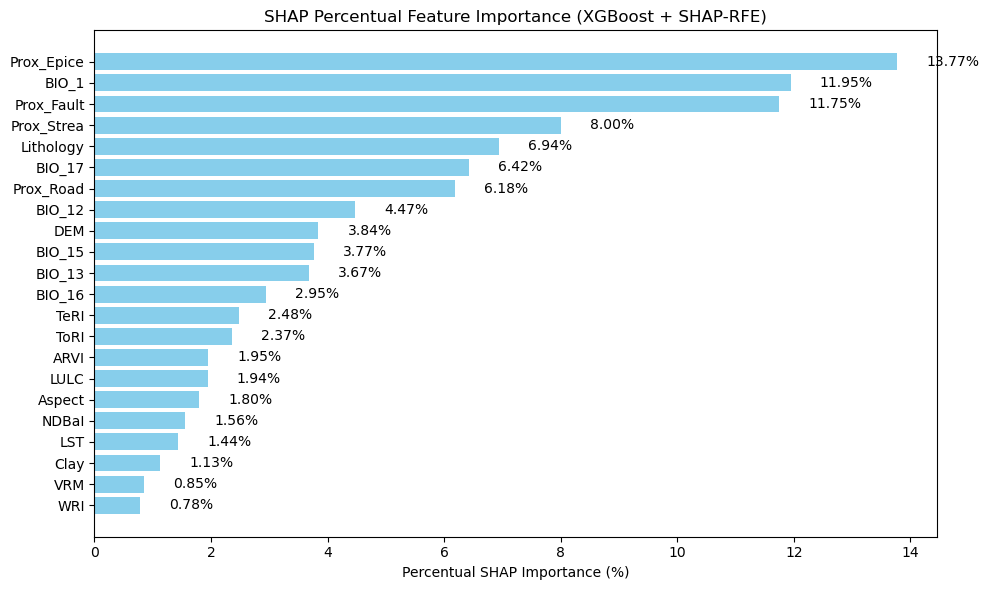

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue')

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,                      # X position (slightly to the right of the bar)
             bar.get_y() + bar.get_height() / 2,  # Y position (center of the bar)
             f"{width:.2f}%",                  # Text (formatted percentage)
             va='center', ha='left', fontsize=10)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Percentual Feature Importance (XGBoost + SHAP-RFE)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_SHAPFS_XGBoost.png")
plt.show()


In [32]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")


Total SHAP Percentage: 99.999992%


In [33]:
# Load the model and selected features
model_path = "models/DeepSwarm_XGBoost.pkl"
model, selected_features = joblib.load(model_path)

X_selected = X[selected_features]

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_selected)

num_features = X_selected.shape[1]
# --- SHAP Summary Plot (dot view + bar) ---
plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="dot", show=False, max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_dot_DeepSwarmXGBoost.png", dpi=300)
plt.close()

plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False,max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_bar_DeepSwarmXGBoost.png", dpi=300)
plt.close()

print("✅ SHAP summary plots saved in 'figures/' folder.")

✅ SHAP summary plots saved in 'figures/' folder.


In [34]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_XGBoost_DeepSwarm.csv", index=False)

       Feature  SHAP_Importance_%
28       BIO_1          20.481956
27  Prox_Epice          16.711670
0          DEM          16.270872
26  Prox_Strea          14.018523
17         LST           4.087128
8         ARVI           3.627209
2          TWI           3.026366
3    LS_factor           2.678844
20       NDBaI           2.290961
10        NDYI           2.236919
14          CI           2.063165
11       MNDWI           1.990555
24          VV           1.954039
23     Ferrous           1.833929
18         TCW           1.109490
22        Clay           1.097721
13         WRI           1.033214
4         NDVI           0.798678
5        GNDVI           0.563905
9           SR           0.396865
1   Plan_curve           0.371773
21         GCI           0.318173
15         FMI           0.254215
7        OSAVI           0.226205
19        EBBI           0.127317
12        NDMI           0.124633
25       IDPDD           0.116918
16        NDBI           0.096700
6         SAVI

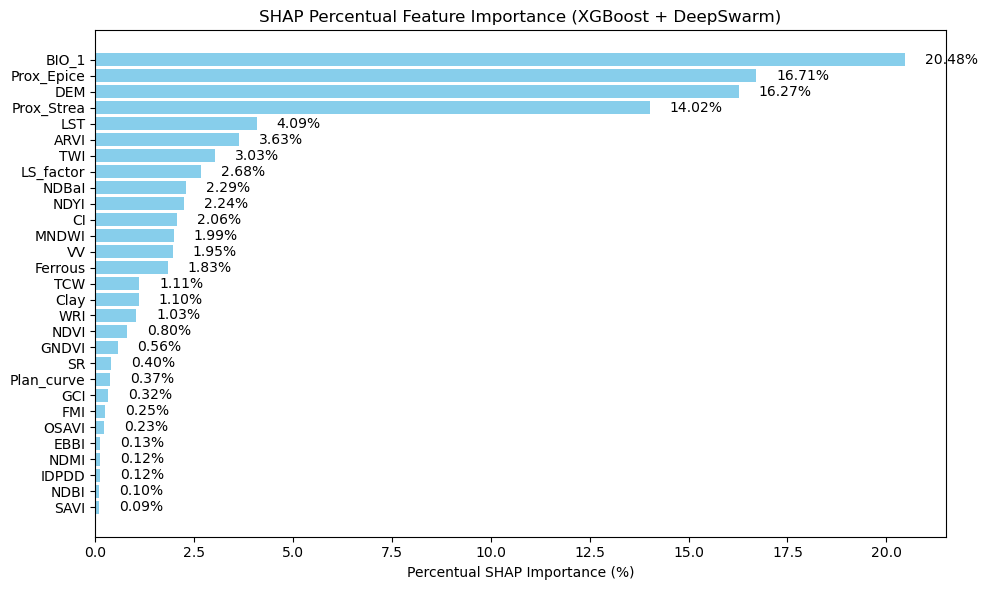

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue')

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,                      # X position (slightly to the right of the bar)
             bar.get_y() + bar.get_height() / 2,  # Y position (center of the bar)
             f"{width:.2f}%",                  # Text (formatted percentage)
             va='center', ha='left', fontsize=10)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Percentual Feature Importance (XGBoost + DeepSwarm)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_DeepSwarm_XGBoost.png")
plt.show()

In [36]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")

Total SHAP Percentage: 100.000023%


In [37]:
# Load the model and selected features
model_path = "models/No_FS_XGBoost.pkl"
model, selected_features = joblib.load(model_path)

X_selected = X[selected_features]

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_selected)

num_features = X_selected.shape[1]
# --- SHAP Summary Plot (dot view + bar) ---
plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="dot", show=False, max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_dot_NoFS_XGBoost.png", dpi=300)
plt.close()

plt.figure()
shap.summary_plot(shap_values, X_selected, plot_type="bar", show=False,max_display=num_features)
plt.tight_layout()
plt.savefig("figures/SHAP_summary_bar_NoFS_XGBoost.png", dpi=300)
plt.close()

print("✅ SHAP summary plots saved in 'figures/' folder.")

✅ SHAP summary plots saved in 'figures/' folder.


In [38]:
# Calculate mean(|SHAP|) per feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
# Convert to percentage
percent_shap = 100 * mean_abs_shap / mean_abs_shap.sum()

# Create DataFrame
shap_percent_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'SHAP_Importance_%': percent_shap
}).sort_values(by='SHAP_Importance_%', ascending=False)

# Show results
print(shap_percent_df)

# Optional: save
shap_percent_df.to_csv("results/shap_percentual_importance_XGBoost_NoFS.csv", index=False)

       Feature  SHAP_Importance_%
61  Prox_Epice          13.018378
60  Prox_Fault          11.049328
62       BIO_1          10.731730
59  Prox_Strea           6.939546
69   Lithology           6.504179
..         ...                ...
27        NDPI           0.000000
25         MSI           0.000000
45  Ratio_VvVh           0.000000
44  Ratio_VhVv           0.000000
48       VDDPI           0.000000

[70 rows x 2 columns]


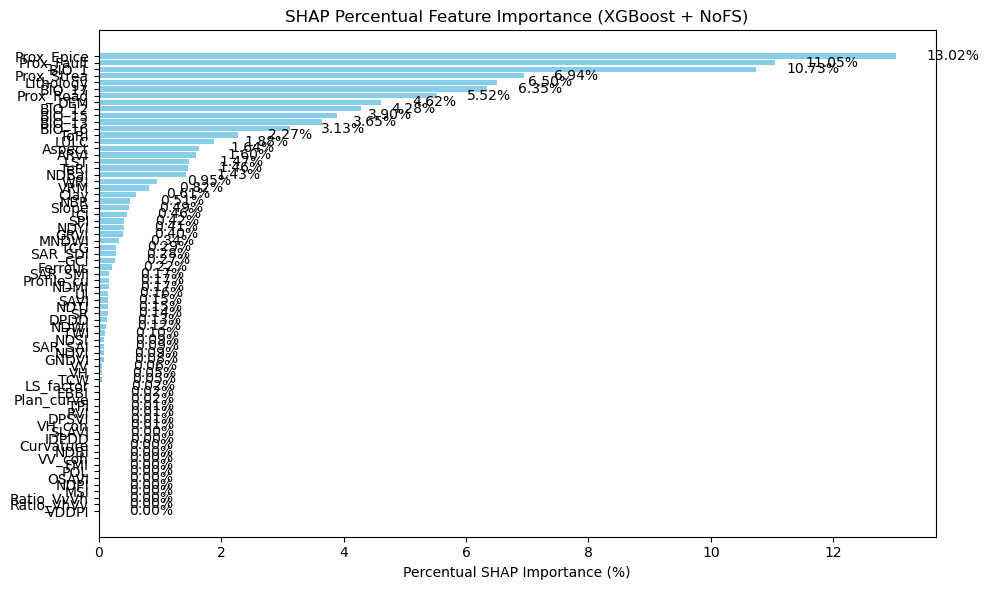

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(shap_percent_df['Feature'], shap_percent_df['SHAP_Importance_%'], color='skyblue')

# Add percentage text next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,                      # X position (slightly to the right of the bar)
             bar.get_y() + bar.get_height() / 2,  # Y position (center of the bar)
             f"{width:.2f}%",                  # Text (formatted percentage)
             va='center', ha='left', fontsize=10)

plt.xlabel("Percentual SHAP Importance (%)")
plt.title("SHAP Percentual Feature Importance (XGBoost + NoFS)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/SHAP_percentual_importance_bar_DeepSwarm_NoFS.png")
plt.show()

In [40]:
total_percent = shap_percent_df["SHAP_Importance_%"].sum()
print(f"Total SHAP Percentage: {total_percent:.6f}%")

Total SHAP Percentage: 100.000008%


In [45]:
import joblib
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# List of your model files
model_files = [
    "models/No_FS_XGBoost.pkl",
    "models/No_FS_CatBoost.pkl",
    "models/No_FS_LightGBM.pkl",
    "models/SHAP_RFE_XGBoost.pkl",
    "models/SHAP_RFE_CatBoost.pkl",
    "models/SHAP_RFE_LightGBM.pkl",
    "models/DeepSwarm_XGBoost.pkl",
    "models/DeepSwarm_CatBoost.pkl",
    "models/DeepSwarm_LightGBM.pkl",
]

# Load models and generate predictions
predictions = {}
for path in model_files:
    model, features = joblib.load(path)
    X_test_sel = X_test[features]
    y_pred = model.predict(X_test_sel)
    predictions[path] = y_pred

# McNemar test helper function
def run_mcnemar(y_true, y_pred1, y_pred2):
    # Build contingency table: [ [both correct, model1 wrong only],
    #                            [model2 wrong only, both wrong] ]
    contingency = np.zeros((2, 2), dtype=int)
    for yt, p1, p2 in zip(y_true, y_pred1, y_pred2):
        correct1 = (p1 == yt)
        correct2 = (p2 == yt)
        contingency[int(correct1), int(correct2)] += 1

    result = mcnemar(contingency, exact=True)
    return result.statistic, result.pvalue

# Run pairwise McNemar tests and collect results
results = []
for i, path1 in enumerate(model_files):
    for j, path2 in enumerate(model_files):
        if j <= i:
            continue
        stat, p = run_mcnemar(y_test.values, predictions[path1], predictions[path2])
        results.append({
            "Model 1": path1.split("/")[-1].replace(".pkl", ""),
            "Model 2": path2.split("/")[-1].replace(".pkl", ""),
            "McNemar Statistic": stat,
            "p-value": p,
            "Significant (p < 0.05)": p < 0.05
        })

# Display results as a DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Optionally save to CSV for later review
df_results.to_csv("results/mcnemar_results.csv", index=False)


               Model 1             Model 2  McNemar Statistic        p-value  \
0        No_FS_XGBoost      No_FS_CatBoost              299.0  2.195791e-208   
1        No_FS_XGBoost      No_FS_LightGBM              229.0   0.000000e+00   
2        No_FS_XGBoost    SHAP_RFE_XGBoost              506.0   2.325081e-04   
3        No_FS_XGBoost   SHAP_RFE_CatBoost              318.0  4.401314e-182   
4        No_FS_XGBoost   SHAP_RFE_LightGBM              230.0   0.000000e+00   
5        No_FS_XGBoost   DeepSwarm_XGBoost              600.0   0.000000e+00   
6        No_FS_XGBoost  DeepSwarm_CatBoost              405.0   0.000000e+00   
7        No_FS_XGBoost  DeepSwarm_LightGBM              407.0   0.000000e+00   
8       No_FS_CatBoost      No_FS_LightGBM              471.0  7.409307e-133   
9       No_FS_CatBoost    SHAP_RFE_XGBoost              267.0  1.006245e-246   
10      No_FS_CatBoost   SHAP_RFE_CatBoost              276.0   1.601569e-04   
11      No_FS_CatBoost   SHAP_RFE_LightG

In [48]:
def interpret_mcnemar_results(df, alpha=0.05):
    critical_value = 3.84  # chi-square critical value for df=1, alpha=0.05

    total_tests = len(df)
    significant_stat = (df['McNemar Statistic'] > critical_value).sum()
    nonsignificant_stat = total_tests - significant_stat

    significant_pval = (df['p-value'] < alpha).sum()
    nonsignificant_pval = total_tests - significant_pval

    print(f"Total pairwise comparisons: {total_tests}\n")

    print(f"Using McNemar statistic > {critical_value} as criterion:")
    print(f"  Significantly different pairs: {significant_stat}")
    print(f"  Not significantly different pairs: {nonsignificant_stat}\n")

    print(f"Using p-value < {alpha} as criterion:")
    print(f"  Significantly different pairs: {significant_pval}")
    print(f"  Not significantly different pairs: {nonsignificant_pval}\n")

    print("Interpretation:")
    print("- McNemar test checks if two classifiers differ significantly in their predictions.")
    print(f"- If McNemar statistic > {critical_value} or p-value < {alpha}, the difference is statistically significant.")
    print("- Otherwise, classifiers are considered statistically similar on the test data.\n")

    if nonsignificant_stat == 0 and nonsignificant_pval == 0:
        print("=> All model pairs show statistically significant differences.")
    else:
        print("=> Some model pairs do not differ significantly.\n")

    # Optionally, print top 5 significant and nonsignificant pairs for insight
    print("Top 5 significant pairs (lowest p-values):")
    print(df[df['p-value'] < alpha].sort_values('p-value').head(5)[
        ['Model 1', 'Model 2', 'McNemar Statistic', 'p-value']])

    print("\nTop 5 nonsignificant pairs (highest p-values):")
    print(df[df['p-value'] >= alpha].sort_values('p-value', ascending=False).head(5)[
        ['Model 1', 'Model 2', 'McNemar Statistic', 'p-value']])
interpret_mcnemar_results(df_results)

Total pairwise comparisons: 36

Using McNemar statistic > 3.84 as criterion:
  Significantly different pairs: 36
  Not significantly different pairs: 0

Using p-value < 0.05 as criterion:
  Significantly different pairs: 36
  Not significantly different pairs: 0

Interpretation:
- McNemar test checks if two classifiers differ significantly in their predictions.
- If McNemar statistic > 3.84 or p-value < 0.05, the difference is statistically significant.
- Otherwise, classifiers are considered statistically similar on the test data.

=> All model pairs show statistically significant differences.
Top 5 significant pairs (lowest p-values):
              Model 1             Model 2  McNemar Statistic  p-value
15     No_FS_LightGBM    SHAP_RFE_XGBoost              225.0      0.0
29  SHAP_RFE_CatBoost  DeepSwarm_LightGBM              710.0      0.0
28  SHAP_RFE_CatBoost  DeepSwarm_CatBoost              711.0      0.0
27  SHAP_RFE_CatBoost   DeepSwarm_XGBoost             1232.0      0.0
25   